# Reading data

In [1]:
from pathlib import Path

data_dir = "Ko"
cha_files = [path.absolute() for path in Path(data_dir).rglob("*.cha")]

In [2]:
import re

def has_korean(s):
    return True if re.search("[\uac00-\ud7a3]", s) else False

def filter_script(line):
    # Lines that start with * mark dialogue
    return line.startswith("*") and has_korean(line)

def transform_script(line):
    transformed = ""
    
    for c in line:
        if has_korean(c) or c == " ":
            transformed += c
    
    return " ".join(transformed.strip().split())

In [3]:
corpus = ""

for file_name in cha_files:
    with open(file_name) as f:
        file_contents = " ".join(transform_script(line) for line in f.readlines() if filter_script(line))
        corpus += f" {file_contents}"

corpus = corpus[1:]

In [4]:
import os

try:
    os.mkdir("out")
except OSError:
    pass

with open(os.path.join("out", "corpus.txt"), "w") as f:
    f.write(corpus)

# Preprocessing

In [5]:
with open(os.path.join("out", "corpus.txt")) as f:
    corpus = f.read()

In [6]:
from konlpy.tag import Mecab
from collections import Counter

mecab = Mecab()  # Parts-of-speech tagger
token_pos = mecab.pos(corpus)

tokens = [token for token, _ in token_pos]
counter = Counter(tokens)
# Number of unique tokens in corpus that occur more than twice; rest are treated as noise
len({ token: count for token, count in counter.items() if count > 2 })

2431

In [7]:
counter = counter.most_common(500)
counter = { token: count for token, count in counter }

In [8]:
token_pos_map = { token: pos.split("+")[0] for token, pos in token_pos if token in counter }

In [9]:
len(set(tokens))  # Number of unique tokens in corpus

5360

In [10]:
len(tokens)  # Number of total tokens in corpus

116455

In [11]:
import numpy as np

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm


token_to_vector = { token: normalize(np.random.normal(size=100)) for token in counter }

In [12]:
import json

with open(os.path.join("out", "token_vector_map.json"), "w") as f:
    json.dump({ token: vector.tolist() for token, vector in token_to_vector.items() }, f)

In [13]:
def average_vector(token):
    before = np.zeros(100)
    after = np.zeros(100)
    before_count = 0
    after_count = 0

    # Sweep a window through processed corpus
    # Calculate the average of all the vectors appearing before and after the token
    for i in range(len(tokens)):
        if tokens[i] == token:
            if i > 0 and tokens[i - 1] in token_to_vector:
                before += token_to_vector[tokens[i - 1]]
                before_count += 1
            if i < len(tokens) - 2 and tokens[i + 1] in token_to_vector:
                after += token_to_vector[tokens[i + 1]]
                after_count += 1

    if before_count != 0:
        before = before / before_count
    if after_count != 0:
        after = after / after_count
                
    return normalize(np.concatenate([before, after]))

In [14]:
# Do one sweep for each unique token, corpus isn't too large anyways
token_to_avg_vector = { token: average_vector(token) for token in counter }

# Training

In [15]:
som_input = np.asarray(list(token_to_avg_vector.values()))

In [16]:
som_input.shape

(500, 200)

In [17]:
from minisom import MiniSom  

# All hyperparameters from Zhao, Li, et al., 2011
som = MiniSom(60, 50, 200, sigma=25, learning_rate=0.5)
som.train(som_input, 400, verbose=True)

 [ 400 / 400 ] 100% - 0:00:00 left 
 quantization error: 0.8706958464238026


# Evaluation

In [18]:
def get_category(pos):
    if pos in ["NNG", "NNP"]:
        return "noun"
    if pos == "VV":
        return "verb"
    if pos in ["VA"]:
        return "adjective"
    if pos in ["NR", "SN"]:
        return "quantifier"
    if pos == "NNBC":
        return "classifier"
    if pos == "MAG":
        return "adverb"
    if pos == "IC":
        return "interjection"
    if pos == "UNKNOWN":
        return "unknown"
    
    return "closed_class"

def get_colour(category):
    map_ = {
        "noun": "yellow",
        "verb": "blue",
        "closed_class": "red",
        "quantifier": "pink",
        "classifier": "cyan",
        "adjective": "green",
        "adverb": "orange",
        "interjection": "purple",
        "unknown": "gray"
    }
    
    return map_[category]

## Visualization

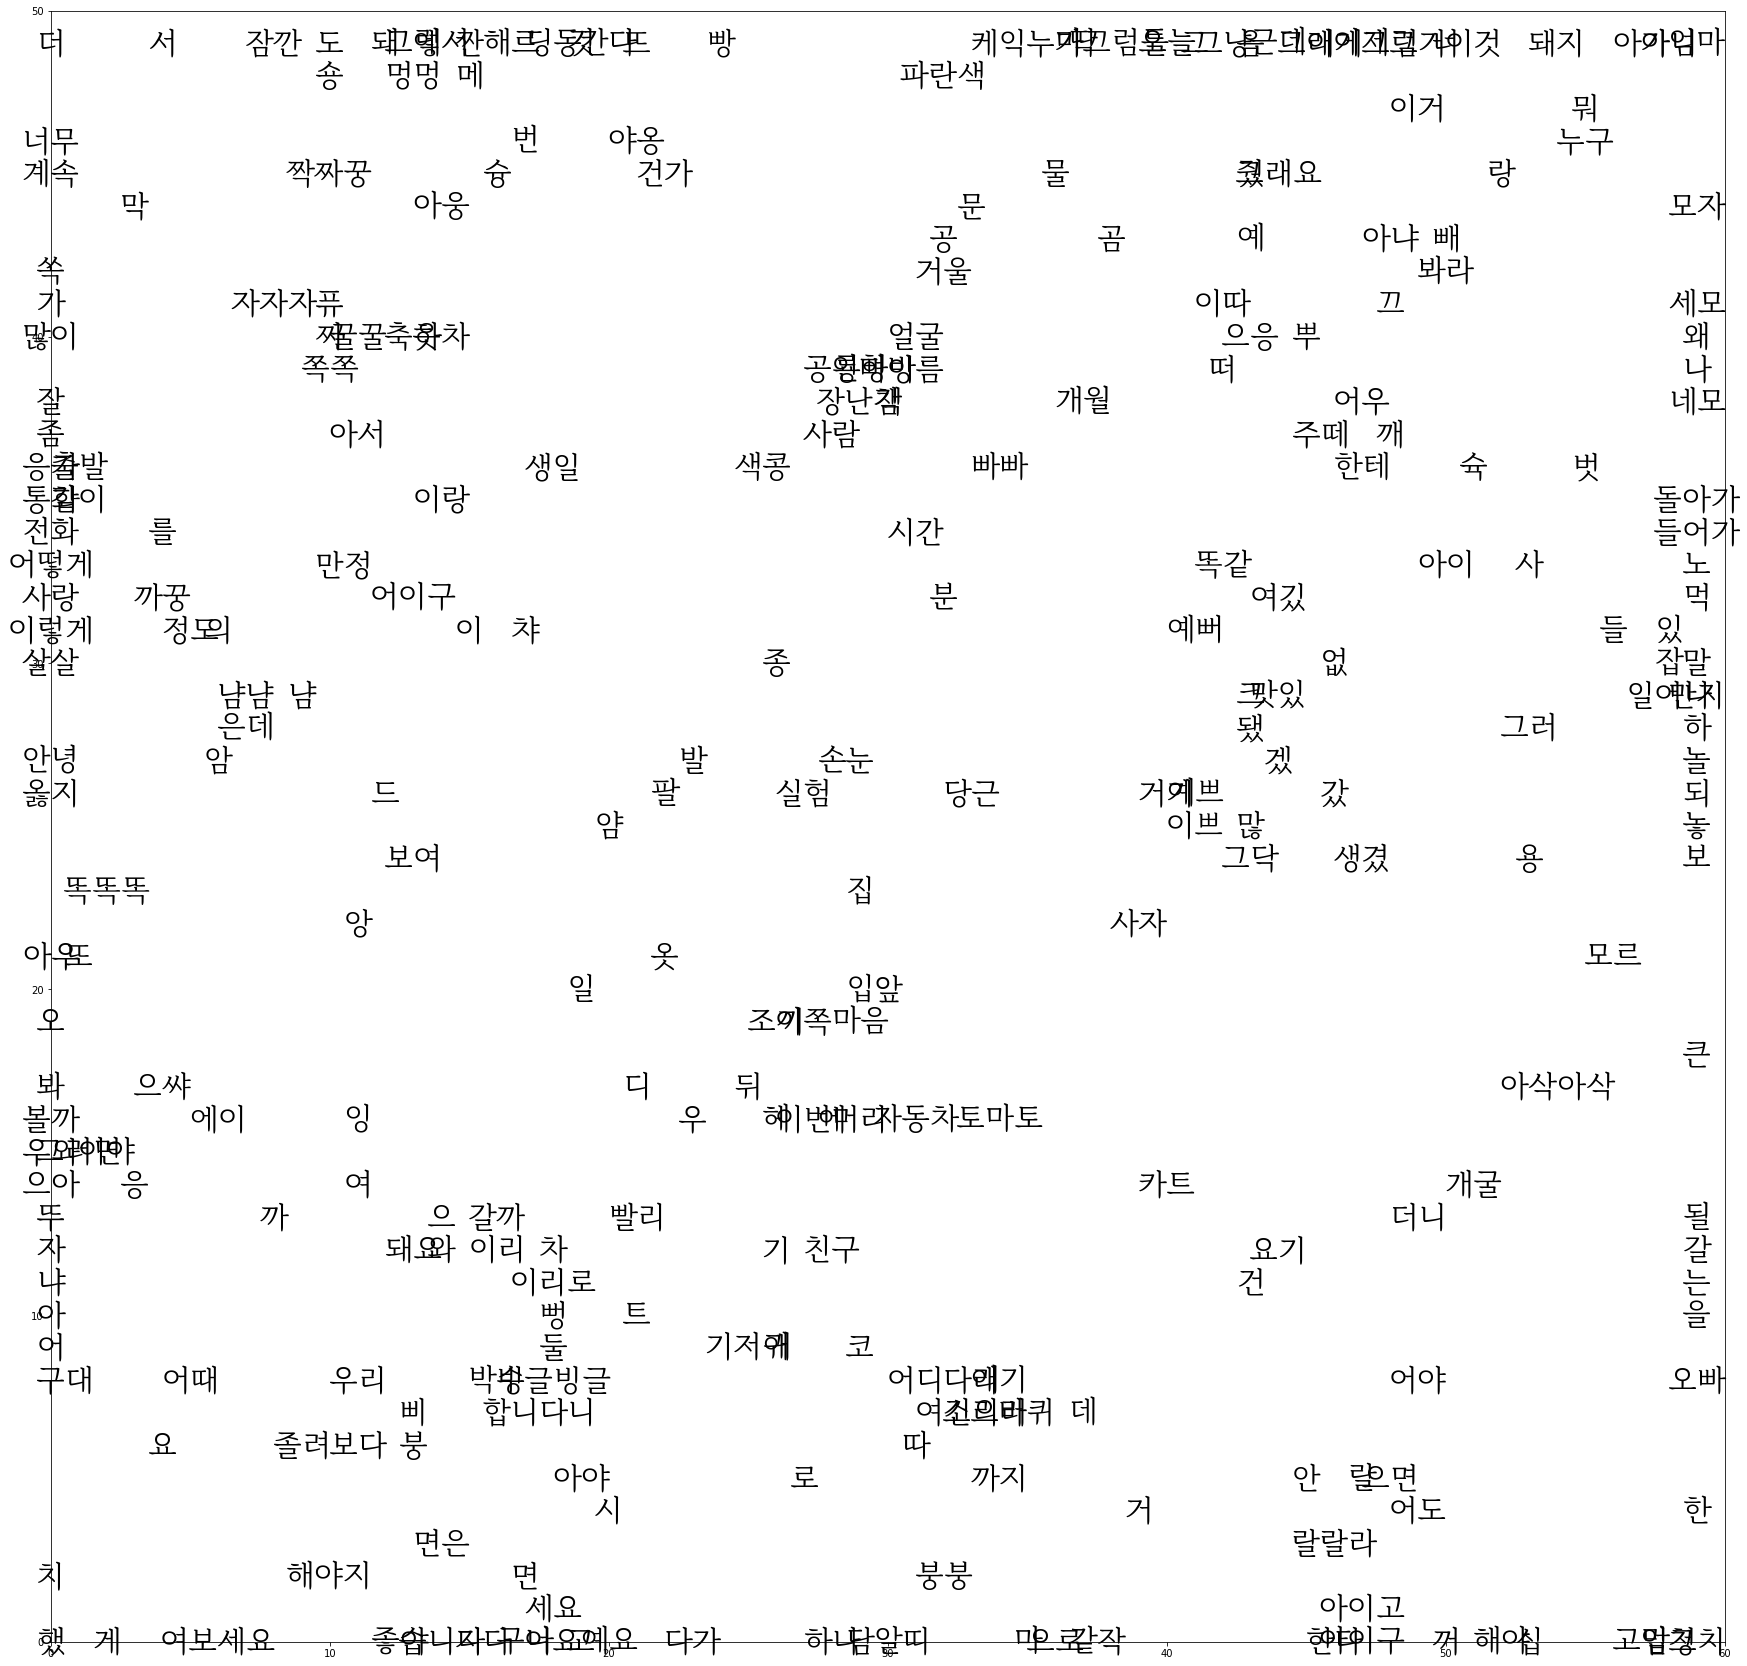

In [19]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fprop = fm.FontProperties(fname='MaruBuri-Regular.ttf')
plt.figure(figsize=(30, 30))
seen = set()

for token, vector in token_to_avg_vector.items():
    position = som.winner(vector)
    
    if position not in seen:
        color = get_colour(get_category(token_pos_map[token]))
        plt.annotate(token, (position[0], position[1]), fontproperties=fprop, fontsize=30, ha="center", va="center")
        seen.add(position)

plt.xlim([0, 60])
plt.ylim([0, 50])
plt.savefig(os.path.join("out", "som.png"))
plt.show()

## Classification rate

In [20]:
all_labels = ["noun", "verb", "closed_class",
              "quantifier", "classifier", "adjective",
              "adverb", "interjection", "unknown"]

positions = []
labels = []

for token, v in token_to_avg_vector.items():
    labels.append(get_category(token_pos_map[token]))
    positions.append(som.winner(v))

positions = np.asarray(positions)
labels = np.asarray(labels)

label_ind = np.asarray([all_labels.index(l) for l in labels])

In [21]:
Counter(labels)

Counter({'closed_class': 160,
         'interjection': 42,
         'noun': 123,
         'adverb': 60,
         'verb': 78,
         'adjective': 24,
         'classifier': 3,
         'quantifier': 8,
         'unknown': 2})

In [22]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=6)  # 6 neighbours since 1 will be the target itself
knn.fit(positions, label_ind)

predictions = knn.predict(positions)

for label in range(len(all_labels)):
    cat_labels = label_ind[label_ind == label]
    cat_predictions = predictions[label_ind == label]
    
    correct = cat_labels == cat_predictions
    correct_percentage = correct.sum() / len(cat_labels)
    print(f"{all_labels[label]} has {correct_percentage} correct")

noun has 0.8373983739837398 correct
verb has 0.5512820512820513 correct
closed_class has 0.7 correct
quantifier has 0.0 correct
classifier has 0.0 correct
adjective has 0.375 correct
adverb has 0.3 correct
interjection has 0.23809523809523808 correct
unknown has 0.0 correct


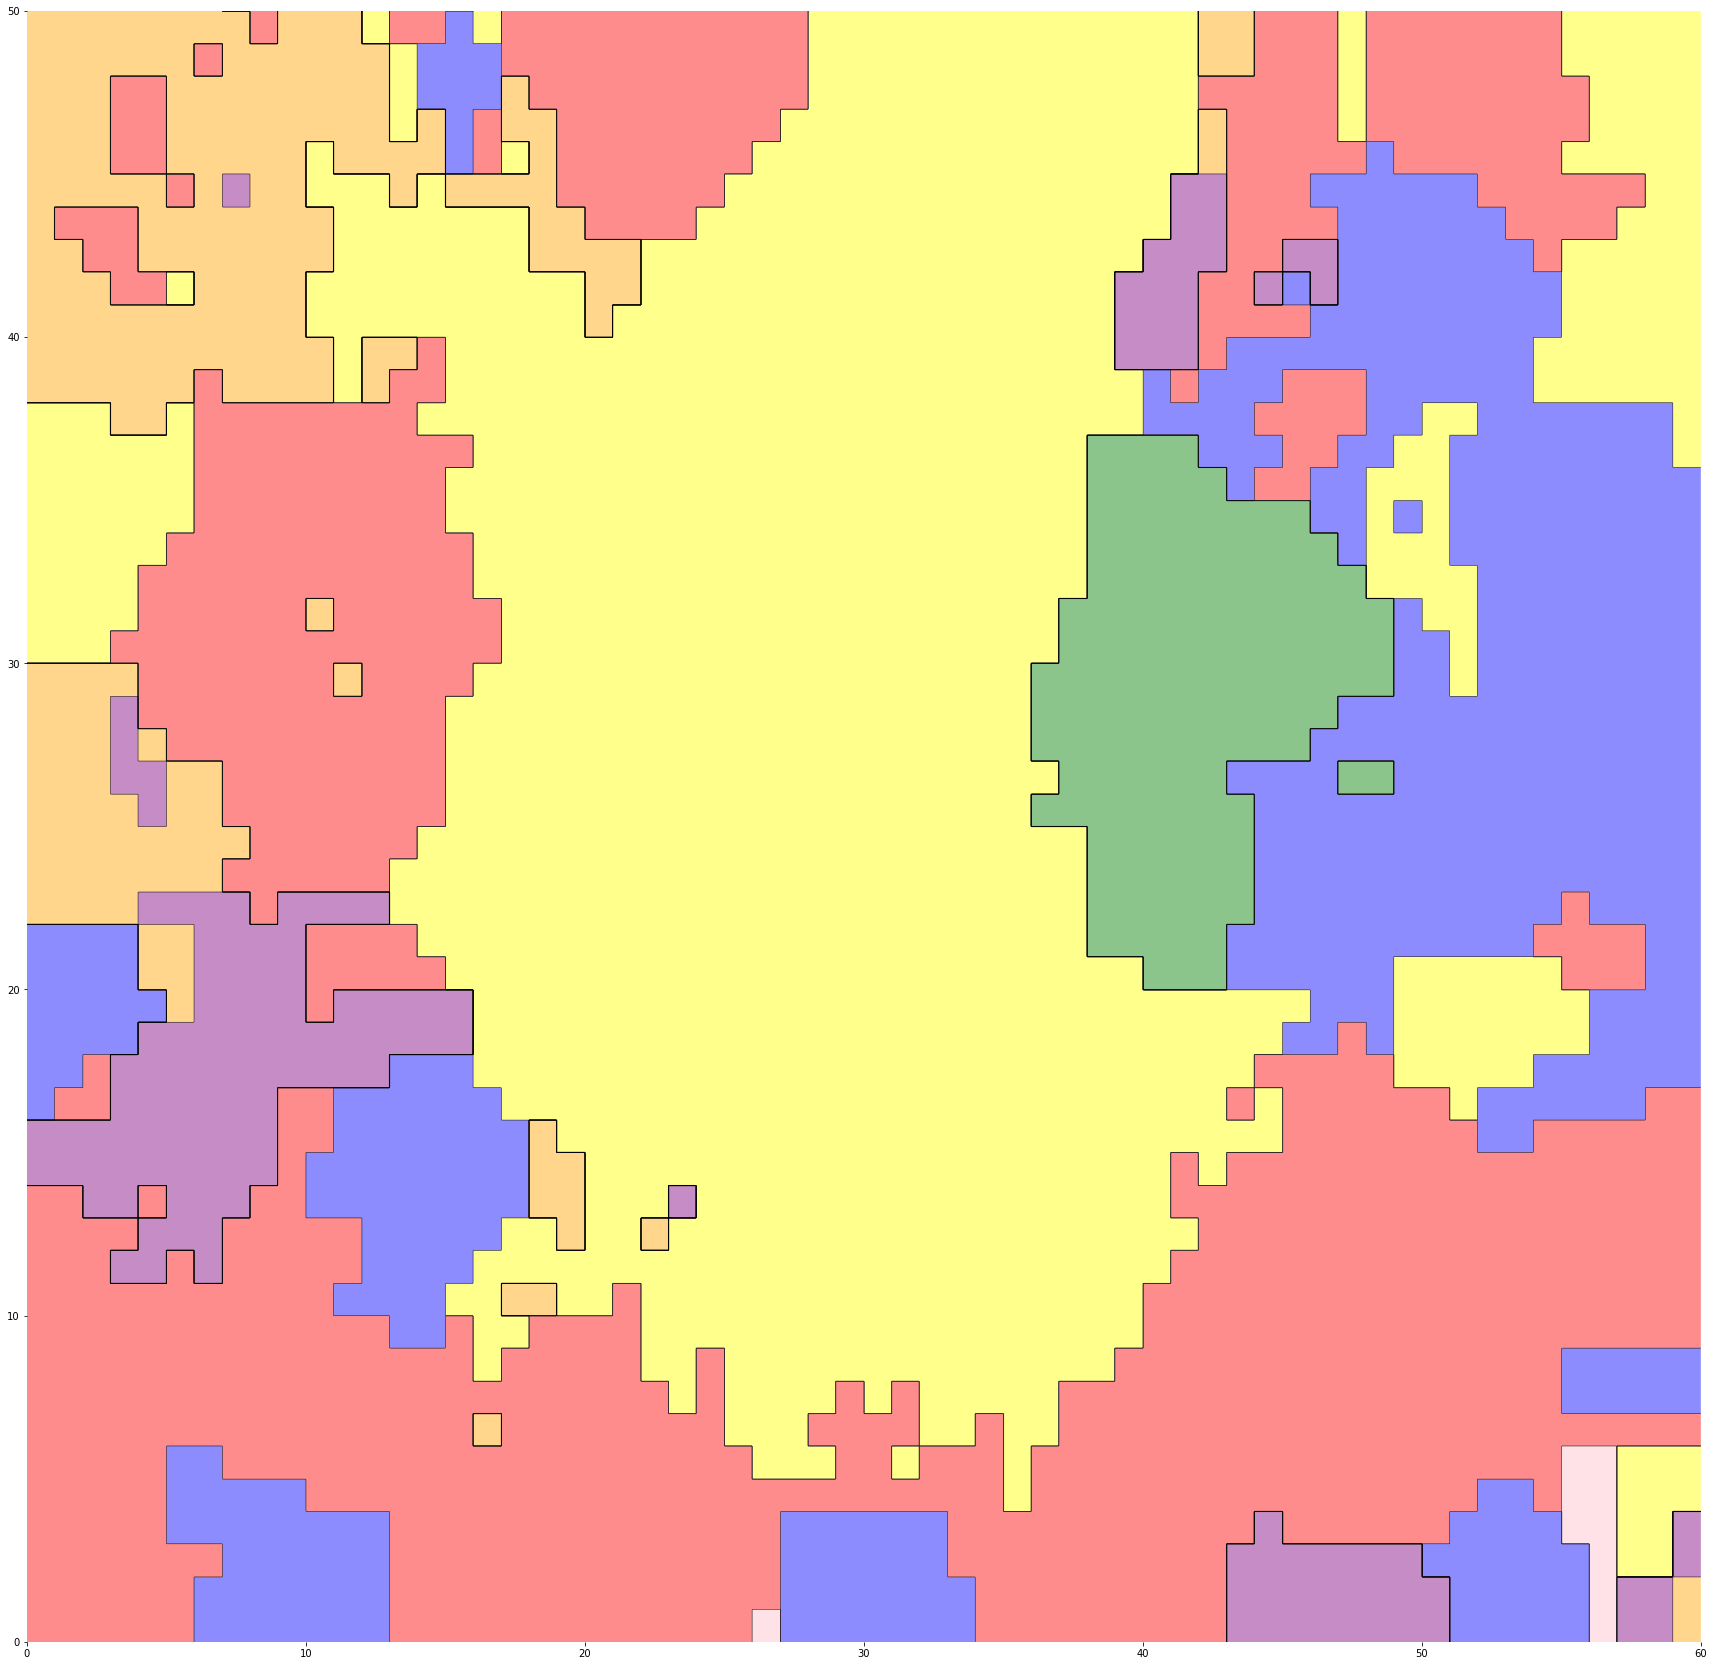

In [23]:
from mlxtend.plotting import plot_decision_regions

label_colours = ",".join([get_colour(l) for l in all_labels])

plt.figure(figsize=(30, 30))
plot_decision_regions(positions, label_ind, clf=knn, colors=label_colours, legend=0, scatter_kwargs={"alpha": 0})

plt.xlim([0, 60])
plt.ylim([0, 50])
plt.savefig(os.path.join("out", "som_regions.png"))
plt.show()